# Environment

<p>The Learning Agent is in search of the only gold box in the given static environment equipped with the metal detectors . The metal detectors are capable of sensing the metal in their own and all surrounding cells in their circumference.</p>
<table>
    <tr>
        <td style="text-align: center;">Environment<img src="Environment.png" width="480" height="480"/></td>
        <td style="text-align: center;">Reward Matrix<img src="Rewards.png" width="480" height="480"/></td>
    </tr>
</table>
<ul>
    <li>Agent initial battery is 10000 points.</li>
    <li>Each Forward/Backward/Left/Right movement reduces 1 battery point.</li>
    <li>Each Forward/Backward/Left/Right movement reduces 1 battery point.</li>
    <li>We assume that the action/movement is deterministic.</li>
    <li>Falling within range of metal detecting sensor cell reduces 100 battery point. <b style="color: red">Here it assumed that if a cell is within range of two metal detecting sensor it will cause reduction of 200 battery points.</b></li>
    <li>Finding gold box given 10000 battery points.</li>
</ul>

In [1]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# As the environment is static & the agent's starting conditions are same, we define some global constants 
env_rows = 10
env_cols = 10
no_of_actions = 4
initial_battery_points = 10000
intitial_location = np.array([9,0])

# We simplfy the movements of agent by assuming it always faces upwards & doesn't turn. 
# So Forward means up & Downward means down movement 
actions = np.array(['Forward', 'Right', 'Backward', 'Left'])

# Reward

In [3]:
# Since each movement costs 1 battery point we set -1 to all cells.
# For right-bottom corner we add 10000 reward
# For cell containing or adjacent to one metal detectors we substract 100 reward
# For cell adjacent to two metal detectors we substract 200 reward
rewards = np.array([[  -1,   -1,   -1,   -1,   -1,   -1,   -1, -101, -101, -101],
                   [  -1,   -1, -101, -101, -101,   -1,   -1, -101, -101, -101],
                   [  -1,   -1, -101, -101, -101,   -1, -101, -201, -201, -101],
                   [-101, -101, -201, -101, -101,   -1, -101, -101, -101,   -1],
                   [-101, -101, -201, -101, -101,   -1, -101, -101, -101,   -1],
                   [-101, -101, -201, -101, -101,   -1,   -1,   -1,   -1,   -1],
                   [  -1,   -1, -101, -101, -101,   -1,   -1,   -1,   -1,   -1],
                   [  -1,   -1,   -1,   -1,   -1,   -1, -101, -101, -101,   -1],
                   [  -1, -101, -101, -101,   -1,   -1, -101, -101, -101,   -1],
                   [  -1, -101, -101, -101,   -1,   -1, -101, -101, -101, 9999]])
# All Q table values zero
q_table = np.zeros((env_rows, env_cols, no_of_actions)) 

# Algorithm

Here the agent is learning based & there're rewards in the environment from which the agent has to learn about the best sequence of actions. There fore this is a case of <b>Reinforecement Learning</b> and we choose the <b>Q
Learning</b> method to train the agent. 

We consider following as learning parameters
<ul>
    <li><b>epsilon (ϵ - Greedy)</b></li>
        The ϵ parameter helps in trading off between exploration / exploitation. ϵ is chosen as a number between (0,1) and indicator of % of exploitation against exploration. During initial phase of training ϵ is kept relatively low so that agent explores more and updates Q values for explored state. As the training progresses the ϵ value is increased towards 1 so that exploitations is more compared to exploration.
    <li><b>Discount Factor</b></li>
        The discount factor (γ) is indicator of preference for current reward over expected future rewards. It lies within (0, 1) and kept constant throughout training.
    <li><b>Learning rate</b></li>
        This parameter (α) controls the rate of changes to Q-values as the training progresses. It is kept within (0,1) and kept constant throughout training.
    <li><b>No of Episodes</b></li>
        This parameter is for controlling the training period and usually kept at higher values such as 100, 1000, 10000 etc depending on the complexity of the training.
</ul>

In [4]:
# We define a dictionary for learning parameters
lp0 =learning_parameters = {
    "epsilon" : 0.1,
    "gamma" : 0.99,
    "alpha" : 0.99,
    "no_of_episodes" : 100
}

Next we program the Q-Learning algorithm. We define some helper functions before the main function.

In [5]:
# Function to check if episode ended. Goal reached or battery euns out.
def is_end_of_episode(curr_row_idx, curr_col_idx, batt_pts):
    if batt_pts <= 0 or (curr_row_idx == 9 and curr_col_idx == 9):
        return True
    else:
        return False 

def get_next_action_index(curr_row_idx, curr_col_idx, eps):
    if np.random.random() <= eps:                                 # Exploitation
        qs = q_table[curr_row_idx, curr_col_idx]
        qsmaxidx = np.where(qs == qs.max())[0]
        random.choice(qsmaxidx)
        return random.choice(qsmaxidx)
    else: #choose a random action
        return np.random.randint(no_of_actions)                                # Exploration

#define a function that will get the next location based on the chosen action
def get_next_location_index(curr_row_idx, curr_col_idx, action_idx):
    new_row_idx = curr_row_idx
    new_col_idx = curr_col_idx
    if actions[action_idx] == 'Forward' and curr_row_idx > 0:
        new_row_idx -= 1
    elif actions[action_idx] == 'Right' and curr_col_idx < env_cols - 1:
        new_col_idx += 1
    elif actions[action_idx] == 'Backward' and curr_row_idx < env_rows - 1:
        new_row_idx += 1
    elif actions[action_idx] == 'Left' and curr_col_idx > 0:
        new_col_idx -= 1
    return new_row_idx, new_col_idx

def reset_q_table():                                                # For a fresh training 
    q_table = np.zeros((env_rows, env_cols, no_of_actions)) 

def q_learning(learning_parameters,print_Q):
    #reset Q table before calling this function
    
    epsilon = learning_parameters["epsilon"]                      # For using ϵ-Greedy strategy for selecting action
    gamma = learning_parameters["gamma"]                          # Discount Factor
    alpha = learning_parameters["alpha"]                          # Learning rate
    no_of_episodes = learning_parameters["no_of_episodes"]        # No of episodes 
    
    episodes = []
    rewards_received = []    
    epsilons = []
    
    for episode in range(1,no_of_episodes+1):
        row_index = intitial_location[0]
        column_index = intitial_location[1]
        battery_points = initial_battery_points
        rewards_in_episode = 0
        
        while not is_end_of_episode(row_index, column_index, battery_points):
            action_index = get_next_action_index(row_index, column_index, 1 - (1 - epsilon)/episode)
            old_row_index, old_column_index = row_index, column_index    #store the old row and column indexes
            row_index, column_index = get_next_location_index(row_index, column_index, action_index)
            reward = rewards[row_index, column_index]
            battery_points += reward
            rewards_in_episode += reward
            epsilons.append(1 - (1 - epsilon)/episode)
            
            q_old = q_table[old_row_index, old_column_index, action_index]
            temp_diff = reward + (gamma * np.max(q_table[row_index, column_index])) - q_old

            #update the Q-value for the previous state and action pair
            q_new = q_old + (alpha * temp_diff)
            q_table[old_row_index, old_column_index, action_index] = q_new
        episodes.append(episode+1)
        rewards_received.append(rewards_in_episode)        
    print('Training Completed')
    print("Reward Sum on All Episodes: " + str (sum(rewards_received)/no_of_episodes))
    if print_Q:
        print("Final Q Table")
        np.set_printoptions(precision=1,suppress=True)
        print("For Forward Action")
        print(q_table[:,:,0])
        print("For Right Action")
        print(q_table[:,:,1])
        print("For Backward Action")
        print(q_table[:,:,2])
        print("For Left Action")
        print(q_table[:,:,3])
    plt.xlabel('No of Episodes')
    plt.ylabel('Rewards Received')
    plt.plot(episodes, rewards_received)    
    plt.show()

Training Completed
Reward Sum on All Episodes: 9431.11
Final Q Table
For Forward Action
[[  -6.7   -6.7   -6.7   -5.8   -6.7   -6.7   -5.8 -101.     0.     0. ]
 [  -5.8   -6.7   -1.    -4.9   -1.    -6.7   -5.8 -101.     0.     0. ]
 [  -5.8   -5.8 -101.  -100.     0.    -6.7   -4.8 -100.  -100.  -101. ]
 [  -2.    -2.  -100.  -100.  -100.    -5.8 -100.  -199.  -201.  -102. ]
 [   0.  -101.  -199.  -100.     0.    -6.7 -101.9 -100.  -100.    -3.9]
 [-100.  -200.  -199.  -100.     0.    -5.8 -102.  -100.  -100.    -3.9]
 [-102.  -103.9 -199.  -100.  -100.    -5.9   -4.9   -4.9 9406.1   -3. ]
 [ -12.1  -12.2 -100.  -104.8 -103.  9312.9   -2.    -2.  9505.    -2. ]
 [8762.1 8763.    -6.7   -7.6   -8.6 9214.2 -100.     0.     0.     0. ]
 [8673.5 -102.  -101.  -102.    -8.6   -8.6 -100.  -100.     0.     0. ]]
For Right Action
[[  -5.8   -5.8   -5.8   -5.8   -5.8   -5.8 -101.  -100.     0.     0. ]
 [  -7.6 -100.  -100.  -100.    -2.    -6.7 -101.  -100.     0.  -100. ]
 [  -5.8 -101.  -1

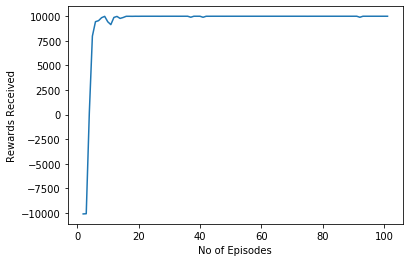

In [6]:
reset_q_table()
q_learning(lp0,True)

# Adjust the learning parameters

In [7]:
# We create four more learning parameters set. We keep epsilon & no_of_episodes unchanged.

lp1 = learning_parameters = {
    "epsilon" : 0.01,
    "gamma" : 0.01,
    "alpha" : 0.01,
    "no_of_episodes" : 100
}
lp2 = learning_parameters = {
    "epsilon" : 0.01,
    "gamma" : 0.01,
    "alpha" : 0.99,
    "no_of_episodes" : 100
}
lp3 = learning_parameters = {
    "epsilon" : 0.01,
    "gamma" : 0.99,
    "alpha" : 0.01,
    "no_of_episodes" : 100
}
lp4 = learning_parameters = {
    "epsilon" : 0.01,
    "gamma" : 0.5,
    "alpha" : 0.5,
    "no_of_episodes" : 100
}

Training Completed
Reward Sum on All Episodes: 9727.23


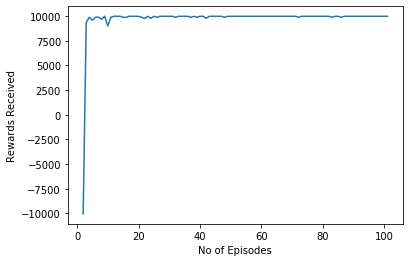

In [8]:
reset_q_table()
q_learning(lp1, False)

Training Completed
Reward Sum on All Episodes: 9732.15


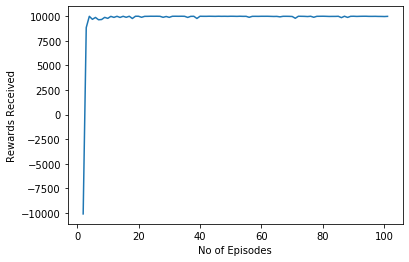

In [9]:
reset_q_table()
q_learning(lp2, False)

Training Completed
Reward Sum on All Episodes: 9660.06


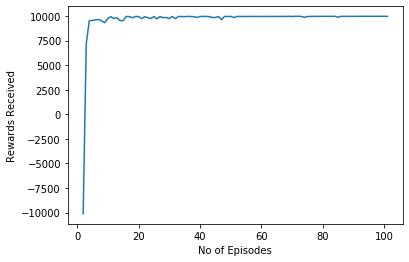

In [10]:
reset_q_table()
q_learning(lp3, False)

Training Completed
Reward Sum on All Episodes: 9670.14


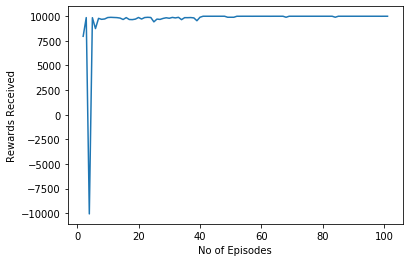

In [11]:
reset_q_table()
q_learning(lp4, False)

From above we see that 2nd set of parameters {"epsilon" : 0.01, "gamma" : 0.01, "alpha" : 0.99, "no_of_episodes" : 100) has led to faster convergnce to solution with minimum noise. The results are subject to be different in different run (training). But for all cases the solution is converging after sufficient no of episodes. If general learning rate is higher it will converge faster provided exploaration actions are limited. 

# Optional

Finally we try to move our agent to see if it follows the optimal path. It will the Q tables learned by the last training.

In [12]:
def optimal_path():
    current_row_index, current_column_index = intitial_location[0], intitial_location[1]
    battery_points = initial_battery_points
    path_traverse = np.array([[current_row_index, current_column_index]])
    #path_traverse = np.append(path_traverse, [current_row_index, current_column_index], axis=0)
    
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_end_of_episode(current_row_index, current_column_index, battery_points):
      #get the best action to take
        action_index = get_next_action_index(current_row_index, current_column_index, 1.0) # epsilon 1 indicates 100% exploitation
      #move to the next location on the path, and add the new location to the list
        current_row_index, current_column_index = get_next_location_index(current_row_index, current_column_index, action_index)
        reward = rewards[current_row_index, current_column_index]
        battery_points += reward
        path_traverse = np.append(path_traverse, [[current_row_index, current_column_index]], axis=0)
    print('Path traversed by Agent')
    print(path_traverse)
    
    plt.figure()
    im = plt.imshow(rewards,interpolation='none', cmap="viridis", aspect='equal', vmin=-200, vmax=100)

    ax = plt.gca();

    # Major ticks
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
    plt.plot(path_traverse[:,1],path_traverse[:,0],color="r")
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

Path traversed by Agent
[[9 0]
 [8 0]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [6 5]
 [6 6]
 [6 7]
 [6 8]
 [6 9]
 [7 9]
 [8 9]
 [9 9]]


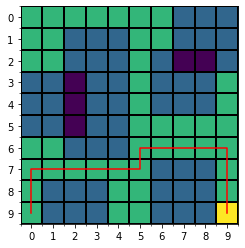

In [13]:
optimal_path()

We observe that the agent has learned to travel along the optimal path